Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install ..  # installing d2l


# Sequence to Sequence with Attention Mechanisms
:label:`sec_seq2seq_attention`

In this section, we add the attention mechanism to the sequence to sequence (seq2seq)
model as introduced in :numref:`sec_seq2seq`
to explicitly aggregate states with weights.
:numref:`fig_s2s_attention` shows the model
architecture for encoding and decoding at the time step $t$. Here, the memory of the
attention layer consists of all the information that the encoder has 
seen---the encoder output at each time step. 
During the decoding, the decoder output from the previous time step $t-1$ is used as the query.
The output of the attention model is viewed as the context information, and such context is concatenated with the decoder input $D_t$.
Finally, we feed the concatenation into the decoder.

![The second time step in decoding for the sequence to sequence model with attention mechanism.](../img/seq2seq_attention.svg)
:label:`fig_s2s_attention`


To illustrate the overall architecture of seq2seq with attention model, the layer structure of its encoder and decoder is shown in :numref:`fig_s2s_attention_details`.

![The layers in the sequence to sequence model with attention mechanism.](../img/seq2seq-attention-details.svg)
:label:`fig_s2s_attention_details`


In [1]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import rnn, nn
npx.set_np()

## Decoder

Since the encoder of seq2seq with attention mechanisms is the same as `Seq2SeqEncoder` in :numref:`sec_seq2seq`, we will just focus on the decoder. We add an MLP attention layer (`MLPAttention`) which has the same hidden size as the LSTM layer in the decoder. Then we initialize the state of the decoder by passing three items from the encoder:

- **the encoder outputs of all time steps**: they are used as the attention layer's memory with identical keys and values;

- **the hidden state of the encoder's final time step**: it is used as the initial decoder's hidden state;

- **the encoder valid length**: so the attention layer will not consider the padding tokens within the encoder outputs.

At each time step of the decoding, we use the hidden state of the decoder's last RNN layer as the query for the attention layer. The attention model's output is then concatenated with the input embedding vector to feed into the RNN layer. Although the RNN layer hidden state also contains history information from decoder, the attention output explicitly selects the encoder outputs based on `enc_valid_len`, so that the attention output suspends other irrelevant information.

Let us implement the `Seq2SeqAttentionDecoder`, and see how it differs from the decoder in seq2seq from :numref:`sec_seq2seq_decoder`.


In [2]:
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention_cell = d2l.MLPAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.LSTM(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, enc_valid_len, *args):
        outputs, hidden_state = enc_outputs
        # Transpose `outputs` to (`batch_size`, `seq_len`, `num_hiddens`)
        return (outputs.swapaxes(0, 1), hidden_state, enc_valid_len)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        X = self.embedding(X).swapaxes(0, 1)
        outputs = []
        for x in X:
            # `query` shape: (`batch_size`, 1, `num_hiddens`)
            query = np.expand_dims(hidden_state[0][-1], axis=1)
            # `context` has same shape as `query`
            context = self.attention_cell(
                query, enc_outputs, enc_outputs, enc_valid_len)
            # Concatenate on the feature dimension
            x = np.concatenate((context, np.expand_dims(x, axis=1)), axis=-1)
            # Reshape `x` to (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.swapaxes(0, 1), hidden_state)
            outputs.append(out)
        outputs = self.dense(np.concatenate(outputs, axis=0))
        return outputs.swapaxes(0, 1), [enc_outputs, hidden_state,
                                        enc_valid_len]

Now we can test the seq2seq with attention model. To be consistent with the model without attention in :numref:`sec_seq2seq`, we use the same hyperparameters for `vocab_size`, `embed_size`, `num_hiddens`, and `num_layers`. As a result, we get the same decoder output shape, but the state structure is changed.


In [3]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8,
                             num_hiddens=16, num_layers=2)
encoder.initialize()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8,
                                  num_hiddens=16, num_layers=2)
decoder.initialize()
X = np.zeros((4, 7))
state = decoder.init_state(encoder(X), None)
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

((4, 7, 10), 3, (4, 7, 16), 2, (2, 4, 16))

## Training

Similar to :numref:`sec_seq2seq_training`, we try a toy model by applying
the same training hyperparameters and the same training loss.
As we can see from the result, since the
sequences in the training dataset are relatively short,
the additional attention
layer does not lead to a significant improvement.
Due to the computational 
overhead of both the encoder's and the decoder's attention layers, this model
is much slower than the seq2seq model without attention.


loss 0.032, 3577.8 tokens/sec on gpu(0)


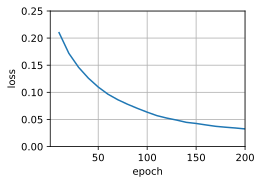

In [4]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, device)

Last, we predict several sample examples.


In [5]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, device))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => j'ai gagné !


## Summary

* The seq2seq model with attention adds an additional attention layer to the model without attention.
* The decoder of the seq2seq with attention model passes three items from the encoder: the encoder outputs of all time steps, the hidden state of the encoder's final time step, and the encoder valid length.

## Exercises

1. Compare `Seq2SeqAttentionDecoder` and `Seq2seqDecoder` by using the same parameters and checking their losses.
1. Can you think of any use cases where `Seq2SeqAttentionDecoder` will outperform `Seq2seqDecoder`?


[Discussions](https://discuss.d2l.ai/t/347)
